In [1]:
# External Dependencies

import random

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.linalg import solve
from scipy.spatial import distance_matrix
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull
from scipy.signal import correlate2d
from scipy.stats import wasserstein_distance
from scipy.stats import pearsonr

import pylops
from pylops.utils.wavelets import ricker

import gstools as gs

from sklearn.metrics.pairwise import cosine_similarity

from skimage.metrics import structural_similarity as ssim

from dtaidistance import dtw

import pywt  # For wavelet transform

from scipy import signal

import torch

DTW C variant not available.

If you want to use the C libraries (not required, depends on cython), then run `cd d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\dtaidistance\..;python3 setup.py build_ext --inplace`.


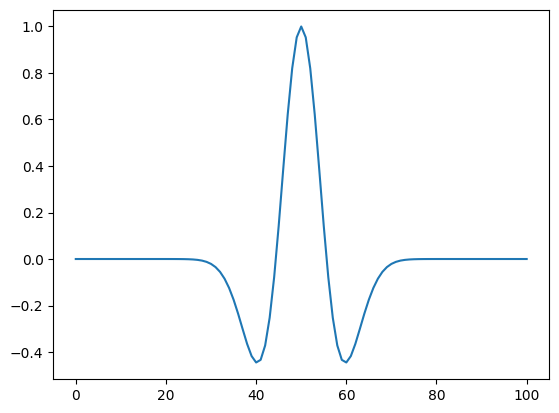

In [2]:
# Grid constants
nx, nz = 100, 100  # Grid size in nx (n, offset) and z (depth) directions
x = np.linspace(0, nx-1, nx)
z = np.linspace(0, -(nx-1), nz)
x_grid, z_grid = np.meshgrid(x, z)

# Impedance values
salt_impedance = 1
rock_impedance = 0

# Wavelet
nt0 = 51
dt0 = 0.002
t0 = np.arange(nt0) * dt0
ntwav = 101
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 20)

plt.plot(wav)

# PyLops dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)
# PyLops lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

In [3]:
# Structure functions

# Layers
def create_structure(type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq):
    structure = np.full((nz, nx), rock_impedance)
    structure_depth = structure_depth
    structure_radius = structure_radius
    structure_amplitude = structure_amplitude
    structure_freq = structure_freq

    if type == 'flat':
        for i in range(nz):
            for j in range(nx):
                # Flat shape
                depth = structure_depth
                if i < depth:
                    structure[i, j] = salt_impedance

    if type == 'dip':
        for i in range(nz):
            for j in range(nx):
                # Dipping shape
                depth = structure_depth + j * struct_dip
                if i < depth:
                   structure[i, j] = salt_impedance
    
    if type == 'dome':
        for i in range(nz):
            for j in range(nx):
                # Parabolic shape
                depth = structure_depth + (j - nx // 2)**2 / (2 * structure_radius)
                if i < depth:
                   structure[i, j] = salt_impedance

    if type == 'sin':
        for i in range(nz):
            for j in range(nx):
                # Sinusoidal shape
                depth = structure_depth + structure_amplitude * np.sin(j * structure_freq)
                if i < depth:
                   structure[i, j] = salt_impedance

    return structure


# Boundaries
def create_structure_boundary(type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq):
    if type == 'flat':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth

    if type == 'dip':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + j * struct_dip

    if type == 'dome':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + 10 * np.sin(j*0.1)

    if type == 'sin':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + structure_amplitude * np.sin(j * structure_freq)
    
    return boundary_depth

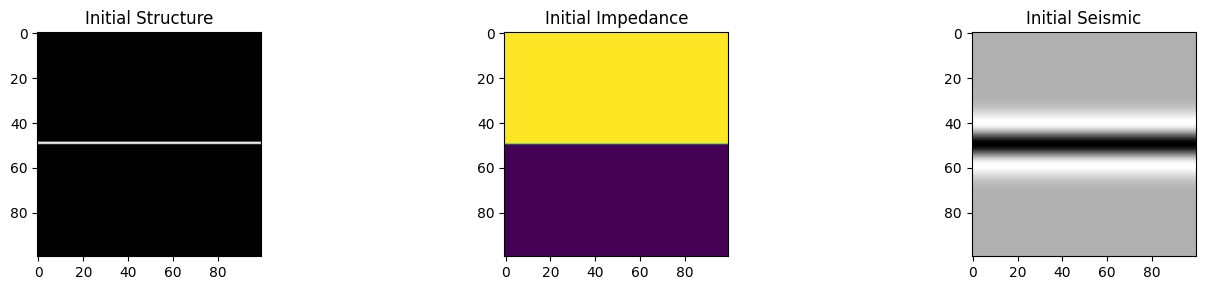

In [4]:
# Creat initial structure

structure_type = 'flat'
structure_depth = 50
structure_radius = 20
struct_dip=0.5
structure_freq = 0.1
structure_amplitude = 10


initial_structure = create_structure(type=structure_type,
                                     structure_depth=structure_depth,
                                     structure_radius=structure_radius,
                                     struct_dip=struct_dip,
                                     structure_amplitude=structure_amplitude,
                                     structure_freq=structure_freq
                                    )
#structure_type = 'sin'
#initial_structure = initial_structure + create_structure(type=structure_type,
#                                                         structure_depth=structure_depth,
#                                                         structure_radius=structure_radius,
#                                                         struct_dip=struct_dip,
#                                                         structure_amplitude=structure_amplitude,
#                                                         structure_freq=structure_freq
#                                                        )


# Shift and substraction of initial structure to obtain the structure boundary
initial_structure_temp = np.zeros((nz, nx))
initial_structure_temp[0:nz-1, :] = initial_structure[1:, :]
initial_structure_boundary = initial_structure - initial_structure_temp
initial_structure_boundary[nz-1, :] = 0

# Initial seismic data for the initial structure
initial_mi = initial_structure
initial_di = (PPop_dense * initial_mi.ravel()).reshape(nz, nx)
initial_ni = np.random.normal(0, 0.1e-1, initial_di.shape)
initial_dn = initial_di + 0


# Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# RF perturbations
axes[0].imshow(initial_structure_boundary, cmap="gray")
axes[0].set_title("Initial Structure")

# Impedance
axes[1].imshow(initial_structure, cmap="viridis")
axes[1].set_title("Initial Impedance")

# Seismic
axes[2].imshow(initial_dn, cmap="gray")
axes[2].set_title("Initial Seismic")


plt.tight_layout()
plt.show()

In [5]:
# Definitions of functions for model generation

# Impedance
def generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget, sill, current_range):

    # Run SRF with added initial structure as the base
    len_sc = current_range
    model = gs.Gaussian(dim=1, var=sill, len_scale=len_sc)
    srf = gs.SRF(model, mean=0)
    #simulated_realization = srf((np.linspace(0, nx-1, nx)), mesh_type="structured")
    simulated_realization = srf.structured(np.linspace(0, nx-1, nx))

    # Structure and perturbation
    boundary_depth = create_structure_boundary(type=random.choice(['flat','dip','dome','sin']),
                                               #type='flat',
                                               structure_depth=structure_depth,
                                               structure_radius=structure_radius,
                                               struct_dip=struct_dip,
                                               structure_amplitude=structure_amplitude,
                                               structure_freq=structure_freq
                                              )
    perturbed_structure = np.full((nz, nx), rock_impedance)
    perturbed_depth = boundary_depth + simulated_realization
    for i in range(nz):
        for j in range(nx):
            depth = perturbed_depth[j]
            if i < depth:
                perturbed_structure[i, j] = salt_impedance

    # Return perturbed structure
    return perturbed_structure, simulated_realization
  

#Seismic
def generate_seismic_model(impedance):

    # Generate corresponding seismic data for impedance
    m = impedance
    # data
    d = (PPop_dense * m.ravel()).reshape(nz, nx)
    n = np.random.normal(0, 0.1e-1, d.shape)
    dn = d + n

    # Return seismic
    return dn


# Covariance function
def compute_covariance_2D(data, range_param, sill):
    n_rows, n_cols = data.shape
    grid_points = np.array([(i, j) for i in range(n_rows) for j in range(n_cols)])
    distances = cdist(grid_points, grid_points, metric='euclidean')
    
    # Exponential variogram model
    covariance_matrix = sill * np.exp(-distances / range_param)
    
    # Return covariance matrix
    return covariance_matrix

In [6]:
# Difference functions

# SSIM Index
def compute_ssim(simulated_data, observed_data):
    # Calculate the data range from the observed data
    data_range = observed_data.max() - observed_data.min()
    ssim_value, _ = ssim(simulated_data, observed_data, data_range=data_range, full=True)    
    return ssim_value


def compute_mae(simulated_data, observed_data):    
    return np.mean(np.abs(simulated_data - observed_data))


def compute_nrmse(simulated_data, observed_data):
    rmse = np.sqrt(np.mean((simulated_data - observed_data)**2))
    data_range = observed_data.max() - observed_data.min()    
    return rmse / data_range


def compute_correlation(simulated_data, observed_data):    
    return np.corrcoef(simulated_data.flatten(), observed_data.flatten())[0, 1]


def compute_dtw(simulated_data, observed_data):
    distances = []
    for row_sim, row_obs in zip(simulated_data, observed_data):
        distance = dtw.distance(row_sim, row_obs)
        distances.append(distance)    
    return np.mean(distances)


def compute_energy_difference(simulated_data, observed_data):
    energy_sim = np.sum(simulated_data**2)
    energy_obs = np.sum(observed_data**2)    
    return np.abs(energy_sim - energy_obs) / energy_obs


def compute_emd(simulated_data, observed_data):    
    return wasserstein_distance(simulated_data.flatten(), observed_data.flatten())


def compute_cross_correlation(simulated_data, observed_data):
    cross_corr = correlate2d(simulated_data, observed_data, mode="valid")        
    return np.max(cross_corr)  # Peak correlation value

# Kernel stops working
#def pearsonr(simulated_data, observed_data):
#    corr, _ = pearsonr(simulated_data, observed_data)
#    return corr


# Pearson Correlation
def compute_pearson_correlation(simulated_data, observed_data):

    correlation = np.zeros(nx)

    for i in range (nx):        

        # Arrays
        array1 = simulated_data[:, i]
        array2 = observed_data[:, i]

        # Check that both strings have the same length
        if len(array1) != len(array2):
            raise ValueError("Both strings must have the same length!")

        # Compute the mean of each array
        mean1 = np.mean(array1)
        mean2 = np.mean(array2)

        # Compute the numerator: covariance between the arrays
        covariance = np.sum((array1 - mean1) * (array2 - mean2))

        # Compute the denominator: product of standard deviations
        std1 = np.sqrt(np.sum((array1 - mean1)**2))
        std2 = np.sqrt(np.sum((array2 - mean2)**2))

        # Compute the Pearson correlation coefficient
        correlation[i] = covariance / (std1 * std2)

    return np.exp(-correlation / 2.0)


def compute_element_wise_multiplication(simulated_data, observed_data):

    el_w_mult = np.zeros(nx)

    for i in range (nx):        

        # Arrays
        array1 = simulated_data[:, i]
        array2 = observed_data[:, i]

        el_w_mult[i] = np.sum(np.multiply(array1, array2))

    return np.sum(el_w_mult) / nx

    
# Wavelet transform
def compute_wavelet_transform(simulated_data, observed_data):

    # Images
    image1 = simulated_data
    image2 = observed_data

    # Apply a transformation, e.g., wavelet transform (replace with your transformation)
    coeffs1 = pywt.dwt2(image1, 'haar')
    coeffs2 = pywt.dwt2(image2, 'haar')

    # Extract the approximation and detail coefficients (this is the transformed part)
    cA1, (cH1, cV1, cD1) = coeffs1
    cA2, (cH2, cV2, cD2) = coeffs2

    # Compute SSIM on the wavelet coefficients (approximation and details separately)
    ssim_cA, _ = ssim(cA1, cA2, full=True, data_range=1.0)
    ssim_cH, _ = ssim(cH1, cH2, full=True, data_range=1.0)
    ssim_cV, _ = ssim(cV1, cV2, full=True, data_range=1.0)
    ssim_cD, _ = ssim(cD1, cD2, full=True, data_range=1.0)

    return (1 - ssim_cA * ssim_cH * ssim_cV * ssim_cD)


# Wavelet transform
def compute_difference_and_total_sum(simulated_data, observed_data):

    return np.sum(simulated_data - observed_data)


# Cosine Similarity
def compute_cosine_similarity_seismic(simulated_data, observed_data):

    seismic1_flat = simulated_data.flatten().reshape(1, -1)
    seismic2_flat = observed_data.flatten().reshape(1, -1)
    
    return cosine_similarity(seismic1_flat, seismic2_flat)[0, 0]

In [8]:
# Definitions of functions for the MCMC

# Likelihood function
def compute_likelihood(simulated_data, observed_data):

    """Calculates the likelihood based on the mean squared error."""
    mse = np.mean((simulated_data - observed_data)**2)
    #ssim_error = compute_semblance(simulated_data, observed_data)
    # Convert MSE to a likelihood, assuming Gaussian errors
    #likelihood = np.exp(-ssim_error / 2.0)

    #likelihood = np.log(ssim_error)
    likelihood = mse

    return likelihood

# Bayesian MCMC sampling for the range parameter
def mcmc_bayesian_estimation(observed_data, current_range, step_size, n_samples):
    
    """MCMC to estimate the posterior distribution of the range parameter."""
    # MCMC Posterior distribution
    samples = []
    # Models through iterations, for plot and QC
    len_sc_list = []
    realizations_SRF = []
    realizations_impedance = []
    realizations_seismic = []

    #current_impedance = sgs_simulation(impedance_1, compute_covariance_2D(impedance_1, range_param=current_range), nugget, sill, current_range)
    current_impedance, current_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=0, sill=variance, current_range=current_range)
    current_seismic = generate_seismic_model(current_impedance)
    current_likelihood = compute_likelihood(current_seismic, initial_dn)

    print(current_likelihood)

    samples.append(current_likelihood)

    # Save current data for plots
    len_sc_list.append(current_range)
    realizations_SRF.append(current_SRF_model)
    realizations_impedance.append(current_impedance)
    realizations_seismic.append(current_seismic)

    for i in tqdm(range(n_samples)):

#        # MCMC
#        # Propose a new range by adding a small Gaussian perturbation
#        proposed_range = current_range + np.random.normal(0, step_size)
#        if proposed_range < prior_range_min or proposed_range > prior_range_max:
#            # Skip if proposed range is outside prior bounds
#            continue
#
#        # Generate seismic data with the proposed range
#        #proposed_impedance = sgs_simulation(current_impedance, compute_covariance_2D(current_impedance, range_param=proposed_range), nugget, sill, proposed_range)
#        proposed_impedance, proposed_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=0, sill=1, current_range=proposed_range)
#        proposed_seismic = generate_seismic_model(proposed_impedance)
#        proposed_likelihood = compute_likelihood(proposed_seismic, observed_data)
#
#        # Acceptance probability (Metropolis-Hastings)
#        acceptance_ratio = proposed_likelihood / current_likelihood
#        #print(acceptance_ratio)
#        if np.random.rand() < acceptance_ratio:
#            # Accept the proposal
#            current_range = proposed_range
#            current_likelihood = proposed_likelihood
#
#        #print(f"Iteration {i}: Proposed range: {proposed_range}, Likelihood ratio: {acceptance_ratio}")
#        #print(f"Observed data mean: {np.mean(observed_data)}, std: {np.std(observed_data)}")
#        #print(f"Initial simulated seismic mean: {np.mean(current_seismic)}, std: {np.std(current_seismic)}")
#
#        # Append the current accepted range to samples
#        samples.append(current_range)
#
#        # Save data for plots
#        len_sc_list.append(proposed_range)
#        realizations_SRF.append(proposed_SRF_model)
#        realizations_impedance.append(proposed_impedance)
#        realizations_seismic.append(proposed_seismic)
        

        # MC
        # Propose a new range by adding a small Gaussian perturbation
        current_range = np.random.uniform(prior_range_min, prior_range_max)

        # Generate seismic data with the proposed range
        #proposed_impedance = sgs_simulation(current_impedance, compute_covariance_2D(current_impedance, range_param=proposed_range), nugget, sill, proposed_range)
        current_impedance, current_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=0, sill=variance, current_range=current_range)
        current_seismic = generate_seismic_model(current_impedance)
        current_likelihood = compute_likelihood(current_seismic, observed_data)

        #print(f"Iteration {i}: Proposed range: {proposed_range}, Likelihood ratio: {acceptance_ratio}")
        #print(f"Observed data mean: {np.mean(observed_data)}, std: {np.std(observed_data)}")
        #print(f"Initial simulated seismic mean: {np.mean(current_seismic)}, std: {np.std(current_seismic)}")

        # Append the current accepted range to samples
        samples.append(current_likelihood)

        # Save data for plots
        len_sc_list.append(current_range)
        realizations_SRF.append(current_SRF_model)
        realizations_impedance.append(current_impedance)
        realizations_seismic.append(current_seismic)

    return np.array(samples), len_sc_list,  realizations_SRF, realizations_impedance, realizations_seismic

In [9]:
# MCMC sampling

# Set random seed for reproducibility
#np.random.seed(42)

# Prior distribution for the variogram parameters
variance = 100
prior_range_min = 1
prior_range_max = 100

## List to store data, for ploting
#realizations_impedance = []
#realizations_seismic = []
#realizations_SRF = []
#len_sc_list = []

# Observed seismic data
observed_data = initial_dn

# MCMC
current_range = np.random.uniform(prior_range_min, prior_range_max)
n_samples = 100
step_size = 2.0
posterior_samples, len_sc_list,  realizations_SRF, realizations_impedance, realizations_seismic = mcmc_bayesian_estimation(observed_data,
                                                                                                                           current_range=current_range,
                                                                                                                           step_size=step_size,
                                                                                                                           n_samples=n_samples
                                                                                                                          )

0.03728091828083831


100%|██████████| 100/100 [00:00<00:00, 191.70it/s]


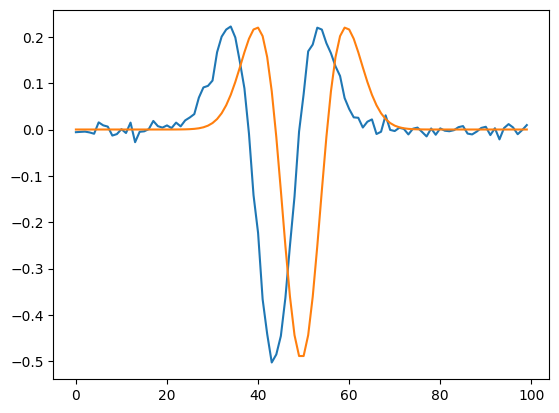

In [ ]:
# Plot two traces from each data set

compute_ssim(observed_data[:, 0], realizations_seismic[4][:, 50])
plt.plot(realizations_seismic[4][:, 4])
plt.plot(observed_data[:, 0])
plt.show()

In [11]:
# QC
posterior_samples

array([0.03728092, 0.03669119, 0.0371146 , 0.04853621, 0.01128887,
       0.03419042, 0.04083789, 0.03620935, 0.03747832, 0.04347472,
       0.03620057, 0.02635471, 0.04442651, 0.04000873, 0.0328315 ,
       0.01893311, 0.0268254 , 0.01644072, 0.0242999 , 0.04048181,
       0.04439964, 0.04167549, 0.01766546, 0.034914  , 0.03310383,
       0.03528015, 0.035807  , 0.02912042, 0.03705697, 0.03395883,
       0.04145278, 0.0307635 , 0.02683114, 0.02849695, 0.03172219,
       0.03317038, 0.03881966, 0.04262406, 0.0356103 , 0.04904698,
       0.02005231, 0.04764003, 0.02353327, 0.04398788, 0.0249942 ,
       0.03213792, 0.03776248, 0.03139622, 0.03511074, 0.03123527,
       0.03906594, 0.03462952, 0.03356141, 0.04028406, 0.05025228,
       0.03728503, 0.04157037, 0.03276335, 0.03419961, 0.03060612,
       0.03641041, 0.01755687, 0.03635431, 0.02667442, 0.03563856,
       0.02796593, 0.0385463 , 0.03681939, 0.03790885, 0.03614547,
       0.04190925, 0.0352836 , 0.03799083, 0.0356999 , 0.02850

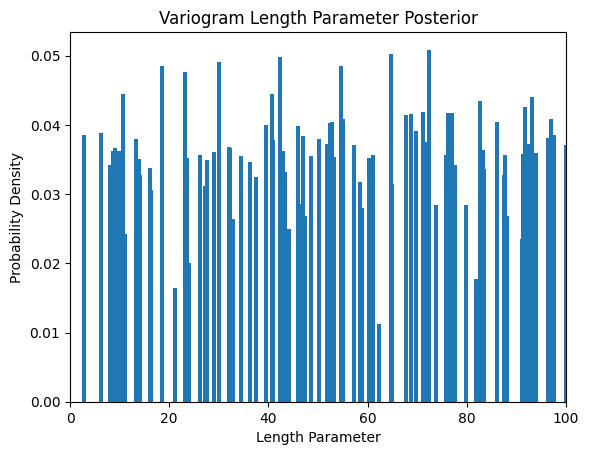

In [12]:
# Plot variogram distribution

# Plot the posterior distribution of the range parameter
#plt.hist(len_sc_list, bins=100, density=True, color="skyblue", edgecolor="black")
plt.bar(len_sc_list, np.abs(posterior_samples))
plt.xlim(0, 100)
#plt.ylim(0, 0.05)
plt.title("Variogram Length Parameter Posterior")
plt.xlabel("Length Parameter")
plt.ylabel("Probability Density")
plt.show()

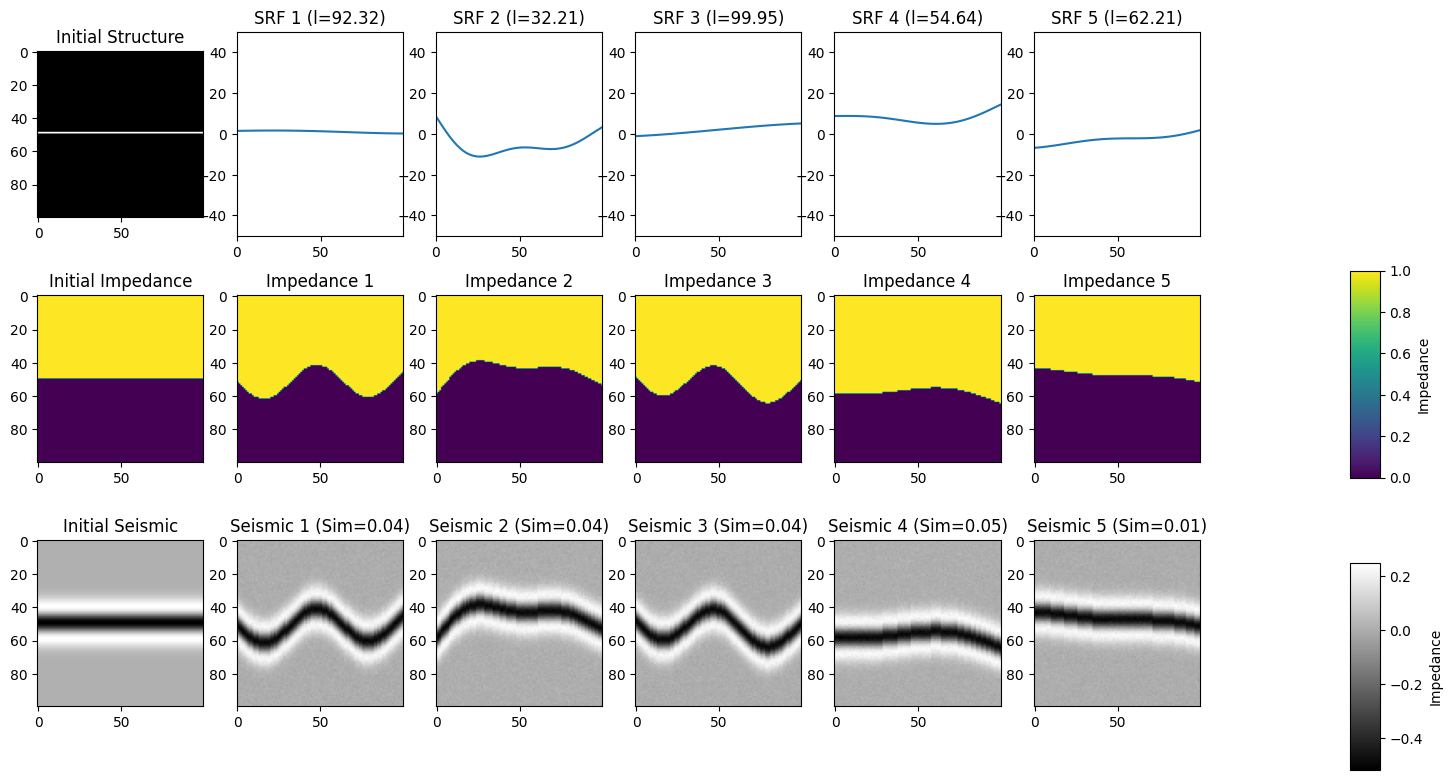

In [13]:
# Plots models

fig, axes = plt.subplots(3, 5 + 1, figsize=(15, 9))

# First row, SRF perturbations
axes[0, 0].imshow(initial_structure_boundary, cmap="gray")
axes[0, 0].set_title("Initial Structure")

for i, realization in enumerate(realizations_SRF[0:5]):
    axes[0, i+1].plot(realization)
    axes[0, i+1].margins(0)
    axes[0, i+1].set_title(f"SRF {i+1} (l={round(len_sc_list[i],2)})")
    axes[0, i+1].set_ylim(-50, 50)

# Second row, impedance realizations
axes[1, 0].imshow(initial_structure, cmap="viridis")
axes[1, 0].set_title("Initial Impedance")

for i in range (5):
    axes[1, i+1].imshow(realizations_impedance[i], cmap="viridis")
    axes[1, i+1].set_title(f"Impedance {i+1}")

# Third row, seismic realizations
axes[2, 0].imshow(initial_dn, cmap="gray")
axes[2, 0].set_title("Initial Seismic")

for i, realization in enumerate(realizations_seismic[0:5]):
    axes[2, i+1].imshow(realization, cmap="gray")
    axes[2, i+1].set_title(f"Seismic {i+1} (Sim={round(posterior_samples[i],2)})")


# Colorbar for impedance
cbar_ax_imp = fig.add_axes([1.0, 0.385, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[1, 1].images[0], cax=cbar_ax_imp, orientation='vertical')
cbar_imp.set_label('Impedance')

# Colorbar for seismic
cbar_ax_seis = fig.add_axes([1.0, 0.06, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[2, 1].images[0], cax=cbar_ax_seis, orientation='vertical')
cbar_imp.set_label('Impedance')


#plt.tight_layout()
plt.show()

In [14]:
# QC
compute_likelihood(initial_dn, initial_dn)
#initial_structure, realizations_seismic[4]

0.0

Similarity Index (SSIM): 0.46033795890854845


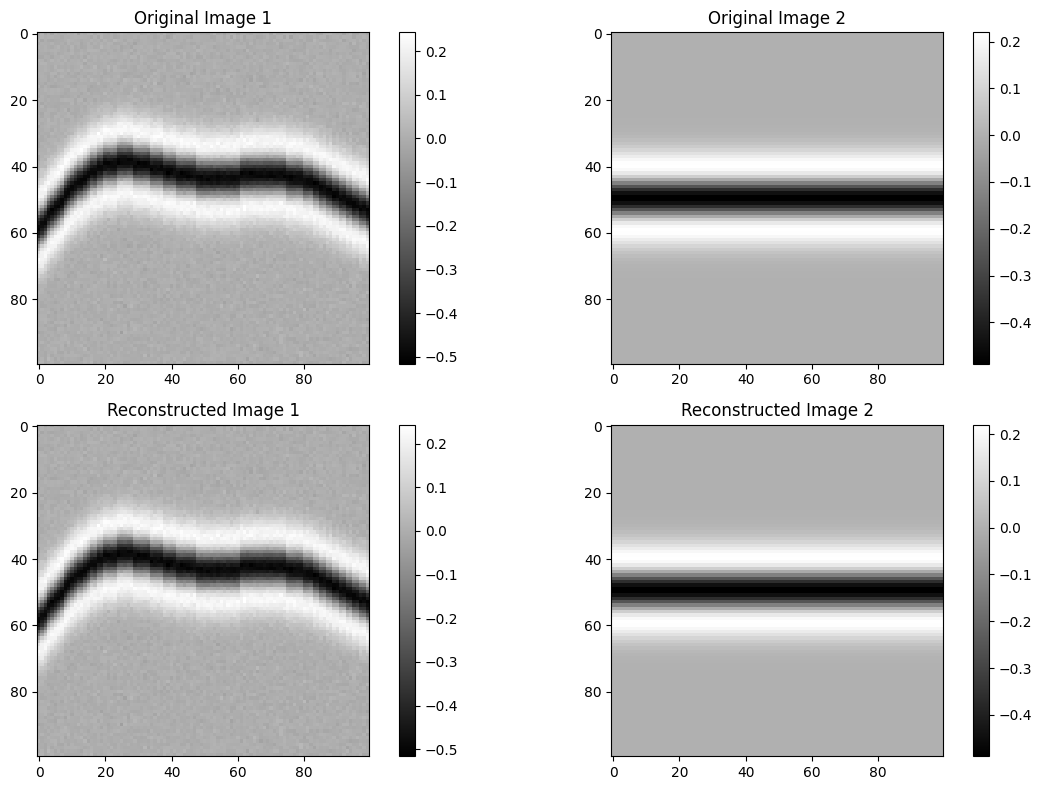

In [15]:
# Testing reconstruction of sections

# Testing Images
image1 = realizations_seismic[1]
image2 = observed_data

# Convert images to PyTorch tensors
image1_tensor = torch.tensor(image1)
image2_tensor = torch.tensor(image2)

# Perform the 2D wavelet transform using PyWavelets (Haar wavelet example)
def wavelet_transform_2d(image):
    # Perform 2D wavelet transform (Haar wavelet)
    coeffs2 = pywt.dwt2(image, 'haar')
    return coeffs2

def inverse_wavelet_transform_2d(coeffs2):
    # Reconstruct the image from wavelet coefficients
    return pywt.idwt2(coeffs2, 'haar')

# Apply wavelet transform to both images
coeffs1 = wavelet_transform_2d(image1)
coeffs2 = wavelet_transform_2d(image2)

# Reconstruct the images from wavelet coefficients
reconstructed_image1 = inverse_wavelet_transform_2d(coeffs1)
reconstructed_image2 = inverse_wavelet_transform_2d(coeffs2)

# Convert the reconstructed images back to NumPy arrays for comparison
reconstructed_image1 = reconstructed_image1
reconstructed_image2 = reconstructed_image2

# Compute Structural Similarity Index (SSIM) between the original images
similarity_index, _ = ssim(image1, image2, full=True, data_range=1)

# Display the SSIM score
print(f"Similarity Index (SSIM): {similarity_index}")

# Plot the original and reconstructed images
plt.figure(figsize=(12, 8))

# Original Images
plt.subplot(2, 2, 1)
plt.imshow(image1, cmap="gray")
plt.title("Original Image 1")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(image2, cmap="gray")
plt.title("Original Image 2")
plt.colorbar()

# Reconstructed Images
plt.subplot(2, 2, 3)
plt.imshow(reconstructed_image1, cmap="gray")
plt.title("Reconstructed Image 1")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(reconstructed_image2, cmap="gray")
plt.title("Reconstructed Image 2")
plt.colorbar()

plt.tight_layout()
plt.show()

In [7]:
# Semblance

window_size = 10

def compute_semblance(observed_data, seismic_section):
    """
    Compute semblance of a seismic section.

    Parameters:
    seismic_section (numpy.ndarray): 2D array of seismic data (traces x time).
    window_size (int): Size of the moving window for semblance calculation.

    Returns:
    numpy.ndarray: 2D semblance map (same size as seismic_section).
    """
    semblance = np.zeros((nz, nx*2))

    for i in range (0, nx):
        semblance[:, 2*i] = observed_data[:, i]
        semblance[:, 2*i+1] = seismic_section[:, i]

    half_window = window_size // 2

    # Compute semblance for each trace and time sample
    for trace_idx in range(0, nx*2):
        for time_idx in range(0, nz):
            # Define the bounds of the moving window
            start_trace = max(0, trace_idx - half_window)
            end_trace = min(nx*2, trace_idx + half_window + 1)
            start_time = max(0, time_idx - half_window)
            end_time = min(nz, time_idx + half_window + 1)

            # Extract the windowed data
            #window_data = seismic_section[start_trace:end_trace, start_time:end_time]
            window_data = semblance[:, start_trace:end_trace][start_time:end_time, :]
            
            # Compute semblance
            num = (np.sum(np.sum(window_data, axis=1)))**2
            denom = window_data.shape[1]*window_data.shape[0] * np.sum((np.sum(window_data**2, axis=1)))
            
            if denom == 0:
                semblance[time_idx, trace_idx] = 0
            else:
                semblance[time_idx, trace_idx] = num / denom

            semblance[time_idx, trace_idx] = num / denom

            semblance_sum = np.sum(np.sum(semblance))

    return semblance, semblance_sum

8697.354898520853


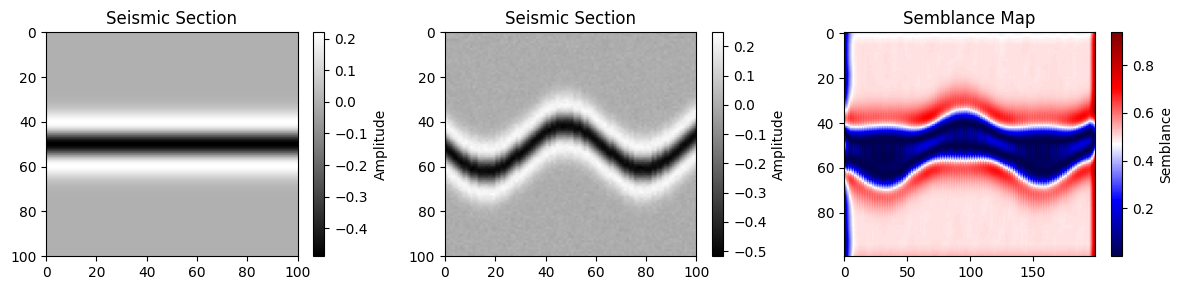

In [16]:
# Semblance

# Create a synthetic 100x100 seismic section (example data)
np.random.seed(42)

# Compute semblance
window_size = 10  # Define a window size
seismic_section = observed_data
semblance_map, semblance_sum = compute_semblance(initial_dn, realizations_seismic[0])

print(semblance_sum)

# Plot the original seismic section and semblance map
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(initial_dn, aspect='auto', cmap='grey', extent=[0, 100, 100, 0])
plt.title("Seismic Section")
plt.colorbar(label="Amplitude")

plt.subplot(1, 3, 2)
plt.imshow(realizations_seismic[0], aspect='auto', cmap='grey', extent=[0, 100, 100, 0])
plt.title("Seismic Section")
plt.colorbar(label="Amplitude")

plt.subplot(1, 3, 3)
plt.imshow(semblance_map, aspect='auto', cmap='seismic')
plt.title("Semblance Map")
plt.colorbar(label="Semblance")

plt.tight_layout()
plt.show()